##### Import package

In [2]:
# conda create -n sss python=3.8 -y && conda activate sss
# conda install -y -c bioconda gffutils jupyter tqdm cyvcf2 pathlib2 pandarallel pysam liftover pybedtools

import os
import re
import numpy as np
import pandas as pd
# from Bio.Seq import Seq
# from liftover import get_lifter
from pathlib2 import Path
from pandarallel import pandarallel
from tqdm import tqdm
import gffutils
import pysam
from cyvcf2 import VCF

### Logging setup
from logging import getLogger, config
import yaml
parent_directory = os.path.dirname(os.path.dirname('__file__'))
config_path: str = os.path.join(parent_directory, '../../../config/logging.yaml')
with open(config_path, 'r') as f:
    config.dictConfig(yaml.safe_load(f))
logger = getLogger(__name__)

########   Initialize and setup pandas methods   ########
os.environ['JOBLIB_TEMP_FOLDER'] = '/tmp' 
pandarallel.initialize(nb_workers=5, progress_bar=True, verbose=1, use_memory_fs=False) 
tqdm.pandas()

import sys
try: 
    __file__
    sys.path.append(os.path.join(os.path.dirname('__file__')))
except NameError:
    Path().resolve()
    sys.path.append(os.path.join(Path().resolve(), '../../../'))

from libs import utils, preprocess, variantfilter, posparser, splaiparser
# from libs import predeffect, scoring
from libs import anno_spliceai, anno_clinvar
from libs.deco import print_filtering_count
# from libs import predeffect
from libs.scoring import Scoring
from libs import predeffect


gencode_gff = '../../../Resources/05_GENCODE_v43lift37/gencode.v43lift37.annotation.sort.gff3.gz'

try:
    db_anno_gencode = '../../../Resources/06_gffutilsdb/gencode.v43lift37.annotation.gtf.db'
    db_anno_intron = '../../../Resources/06_gffutilsdb/gencode.v43lift37.annotation.intron.gtf.db'
    db = gffutils.FeatureDB(db_anno_gencode)
    db_intron = gffutils.FeatureDB(db_anno_intron)
except ValueError:
    db_anno_gencode = '/resources/DBs/gencode.v43lift37.annotation.gtf.db'
    db_anno_intron = '/resources/DBs/gencode.v43lift37.annotation.intron.gtf.db'
    db = gffutils.FeatureDB(db_anno_gencode)
    db_intron = gffutils.FeatureDB(db_anno_intron)

## Thresholds configuration
thresholds_SpliceAI_parser: dict = {
    'TH_min_sALDL': 0.02, 'TH_max_sALDL': 0.2, 
    'TH_min_sAGDG': 0.01, 'TH_max_sAGDG': 0.05,
    'TH_min_GExon': 25, 'TH_max_GExon': 500,
    'TH_sAG': 0.2, 'TH_sDG': 0.2
    }

FileNotFoundError: [Errno 2] No such file or directory: '../../config/logging.yaml'

In [ ]:
## Parse VCF to simple input table
chr: str = "22"
raw_vcf: str = f"splai_vep_vcfs/hgmd_dm/all_DM_chr{chr}.splai.vep.nondel.vcf"

vcf = VCF(raw_vcf)
header = vcf.header_iter()
for h in header:
	try:
		h['ID']
	except KeyError:
		continue
	else:
		if h['ID'] == 'CSQ':
			vep_cols_list = h['Description'].split('Format: ')[1].rstrip('"').split('|')
		elif h['ID'] == 'SpliceAI':
			splai_cols_list = h['Description'].split('Format: ')[1].rstrip('"').split('|')
		else:
			pass

vepidx: dict = {col: i for i, col in enumerate(vep_cols_list)}
splaidx: dict = {col: i for i, col in enumerate(splai_cols_list)}

cols = [
	'CHROM', 'POS', 'REF', 'ALT', 'GeneSymbol', 'SymbolSource', 'HGNC_ID', 
	'ENST', 'HGVSc', 'Consequence', 'EXON', 'INTRON', 'Strand',
	'DS_AG', 'DS_AL', 'DS_DG', 'DS_DL', 'DP_AG', 'DP_AL', 'DP_DG', 'DP_DL', 'maxsplai'
]

# print(vepidx)

df: pd.DataFrame = pd.DataFrame(columns=cols)
for v in VCF(raw_vcf):
	vep: list = v.INFO.get('CSQ').split('|')

	# Get SpliceAI scores
	if v.INFO.get('SpliceAI'):
		splai: list = v.INFO.get('SpliceAI').split(',')[0].split('|')
	else:
		splai = ['NA'] * len(splai_cols_list)

	# Get HGVSc from VEP
	try:
		hgvsc = re.search('(?<=:).*',vep[vepidx['HGVSc']])[0]
	except TypeError:
		hgvsc = "NA"

	# Convert strand to +/- 
	strand = lambda s: '+' if s == '1' else '-'

	# Get max SpliceAI scores
	ds_ag: float = splai[splaidx['DS_AG']]
	ds_al: float = splai[splaidx['DS_AL']]
	ds_dg: float = splai[splaidx['DS_DG']]
	ds_dl: float = splai[splaidx['DS_DL']]
	if splai[splaidx['DP_AG']] == 'NA':
		maxsplai: str = "NA"
	maxsplai: float = max(ds_ag, ds_al, ds_dg, ds_dl)

	# Add df row
	df = pd.concat([df, pd.DataFrame([[
		v.CHROM, v.POS, v.REF, v.ALT[0], 
		vep[vepidx['SYMBOL']], vep[vepidx['SYMBOL_SOURCE']], vep[vepidx['HGNC_ID']], 
		vep[vepidx['Feature']], hgvsc, vep[vepidx['Consequence']], 
		vep[vepidx['EXON']], vep[vepidx['INTRON']],
		strand(vep[vepidx['STRAND']]), 
		ds_ag, ds_al, ds_dg, ds_dl,
		splai[splaidx['DP_AG']], splai[splaidx['DP_AL']], 
		splai[splaidx['DP_DG']], splai[splaidx['DP_DL']],
		maxsplai
	]], columns=cols)], ignore_index=True)

	# if hgvsc == "NA":
	#     logger.warning(f"[{v.CHROM}:{v.POS}] HGVSc not found")
	# if maxsplai == "NA":
	#     logger.warning(f"[{v.CHROM}:{v.POS}] SpliceAI scores not found")

# ALLELE|SYMBOL|DS_AG|DS_AL|DS_DG|DS_DL|DP_AG|DP_AL|DP_DG|DP_DL
# CHROM, POS, REF, ALT, GeneSymbol, NCBI_ID, ENST, ExonIntronNumbers, FLAGS, SYMBOL_SOURCE|



In [135]:
from cyvcf2 import VCF, Writer
chr: str = "22"
raw_vcf: str = f"splai_vep_vcfs/hgmd_dm/all_DM_chr{chr}.splai.vep.nondel.vcf"

psps_description = 'Priortiy Score for Pathogenic Splicing variant screening, ranging 0-9, more higher, more likely pathogenic. -1 means not available'

vcf = VCF(raw_vcf)
vcf.add_info_to_header(
	{'ID': 'PSPS', 
  'Description': psps_description, 
  'Type':'Integer', 
  'Number': '1',
  'HeaderType': 'INFO'
  }
  )

0

In [ ]:
header = vcf.header_iter()

In [ ]:
## Parse VCF to simple input table
chr_list = [str(i) for i in range(1, 23)] + ['X', 'Y']

for chr in chr_list:
    print(f"Processing chr{chr}")
    raw_vcf: str = f"splai_vep_vcfs/hgmd_dm/all_DM_chr{chr}.splai.vep.nondel.vcf"

    vcf = VCF(raw_vcf)
    header = vcf.header_iter()
    for h in header:
        try:
            h['ID']
        except KeyError:
            continue
        else:
            if h['ID'] == 'CSQ':
                vep_cols_list = h['Description'].split('Format: ')[1].rstrip('"').split('|')
            elif h['ID'] == 'SpliceAI':
                splai_cols_list = h['Description'].split('Format: ')[1].rstrip('"').split('|')
            else:
                pass

    vepidx: dict = {col: i for i, col in enumerate(vep_cols_list)}
    splaidx: dict = {col: i for i, col in enumerate(splai_cols_list)}

    cols = [
        'CHROM', 'POS', 'REF', 'ALT', 'GeneSymbol', 'SymbolSource', 'HGNC_ID', 
        'ENST', 'HGVSc', 'Consequence', 'EXON', 'INTRON', 'Strand',
        'DS_AG', 'DS_AL', 'DS_DG', 'DS_DL', 'DP_AG', 'DP_AL', 'DP_DG', 'DP_DL', 'maxsplai'
    ]

    # print(vepidx)

    df: pd.DataFrame = pd.DataFrame(columns=cols)
    for v in VCF(raw_vcf):
        vep: list = v.INFO.get('CSQ').split('|')

        # Get SpliceAI scores
        if v.INFO.get('SpliceAI'):
            splai: list = v.INFO.get('SpliceAI').split(',')[0].split('|')
        else:
            splai = ['NA'] * len(splai_cols_list)

        # Get HGVSc from VEP
        try:
            hgvsc = re.search('(?<=:).*',vep[vepidx['HGVSc']])[0]
        except TypeError:
            hgvsc = "NA"

        # Convert strand to +/- 
        strand = lambda s: '+' if s == '1' else '-'

        # Get max SpliceAI scores
        ds_ag: float = splai[splaidx['DS_AG']]
        ds_al: float = splai[splaidx['DS_AL']]
        ds_dg: float = splai[splaidx['DS_DG']]
        ds_dl: float = splai[splaidx['DS_DL']]
        if splai[splaidx['DP_AG']] == 'NA':
            maxsplai: str = "NA"
        maxsplai: float = max(ds_ag, ds_al, ds_dg, ds_dl)

        # Add df row
        df = pd.concat([df, pd.DataFrame([[
            v.CHROM, v.POS, v.REF, v.ALT[0], 
            vep[vepidx['SYMBOL']], vep[vepidx['SYMBOL_SOURCE']], vep[vepidx['HGNC_ID']], 
            vep[vepidx['Feature']], hgvsc, vep[vepidx['Consequence']], 
            vep[vepidx['EXON']], vep[vepidx['INTRON']],
            strand(vep[vepidx['STRAND']]), 
            ds_ag, ds_al, ds_dg, ds_dl,
            splai[splaidx['DP_AG']], splai[splaidx['DP_AL']], 
            splai[splaidx['DP_DG']], splai[splaidx['DP_DL']],
            maxsplai
        ]], columns=cols)], ignore_index=True)

        # if hgvsc == "NA":
        #     logger.warning(f"[{v.CHROM}:{v.POS}] HGVSc not found")
        # if maxsplai == "NA":
        #     logger.warning(f"[{v.CHROM}:{v.POS}] SpliceAI scores not found")

    # ALLELE|SYMBOL|DS_AG|DS_AL|DS_DG|DS_DL|DP_AG|DP_AL|DP_DG|DP_DL
    # CHROM, POS, REF, ALT, GeneSymbol, NCBI_ID, ENST, ExonIntronNumbers, FLAGS, SYMBOL_SOURCE|

    df.to_pickle(f"splai_vep_vcfs/hgmd_dm/all_DM_chr{chr}.splai.vep.nondel.vcf.pkl")


In [6]:
# df = pd.read_pickle('splai_vep_vcfs/hgmd_dm/all_DM_chr1.splai.vep.pkl')
print(len(df))
df.drop_duplicates(inplace=True)
print(len(df))

20701
20687


In [ ]:
#### Very slow process ####
# Annotate ENST Full ID for fetching variant information from GENCODE database

for chr in chr_list:
	logger.info(f"chr{chr}")
	df = pd.read_pickle(f'splai_vep_vcfs/hgmd_dm/all_DM_chr{chr}.splai.vep.nondel.vcf.pkl')
	df.drop_duplicates(inplace=True)
	df['ENST_Full'] = df.progress_apply(posparser.fetch_enst_full, db=db, axis=1)
	df.to_pickle(f'splai_vep_vcfs/hgmd_dm/all_DM_chr{chr}.splai.vep.nondel.vcf.enst.pkl')

## ここから解析

In [3]:
chr_list = [str(i) for i in range(1, 23)] + ['X', 'Y']
chr_list = ['22']

for chr in chr_list:
    df = pd.read_pickle(f'splai_vep_vcfs/hgmd_dm/all_DM_chr{chr}.splai.vep.nondel.vcf.enst.pkl')

    logger.info('Classify "Canonical" splice site or "Non-canonical" splice site...')
    df = posparser.classifying_canonical(df)

    logger.info('Calculate the distance to the nearest splice site in intron variant...')
    df['IntronDist'] = df.progress_apply(
        posparser.signed_distance_to_exon_boundary, 
        db=db, db_intron=db_intron, axis=1)

    tbx_anno = pysam.TabixFile(gencode_gff)
    df['exon_loc'] = df.progress_apply(
        posparser.calc_exon_loc, tabixfile=tbx_anno, enstcolname='ENST', axis=1)
    df = pd.concat([df, df['exon_loc'].str.split(':', expand=True)], axis=1)
    df.rename(columns={0: 'ex_up_dist', 1: 'ex_down_dist'}, inplace=True)
    df.drop(columns=['exon_loc'], inplace=True)

    #2-2. Select minimum distance from upstream distance and downstream distance
    df['exon_pos'] = df.parallel_apply(posparser.select_exon_pos, axis=1)
    #2-3. Relative exon location
    df['prc_exon_loc'] = df.parallel_apply(posparser.calc_prc_exon_loc, axis=1)

    #2-4. Decision exonic splice sites (1 nt in acceptor site or 3 nts on Donor site)
    df['exon_splice_site'] = df.parallel_apply(posparser.extract_splicing_region, axis=1)

    #3.   Additional Splicing information
    logger.info('Annotating splicing information...')
    #3-1. Annotate splicing type ('Exonic Acceptor' etc.)
    df['SpliceType'] = df.parallel_apply(posparser.select_donor_acceptor, axis=1)

    #5.   Annotate ClinVar varaints interpretations
    logger.info('Annotating ClinVar varaints interpretations...')
    clinvar_file = '../../../Resources/03_ClinVar/variant_summary.snv.grch37.germline.criteria.sort.bed.gz'
    tbx_clinvar = pysam.TabixFile(clinvar_file)
    df['clinvar_same_pos'] = df.progress_apply(
        anno_clinvar.anno_same_pos_vars, tabixfile=tbx_clinvar, axis=1)
    df['clinvar_same_motif'] = df.progress_apply(
        anno_clinvar.anno_same_motif_vars, tabixfile=tbx_clinvar, axis=1)

    logger.info('Parsing SpliceAI results...')
    logger.info('Annotating Exon/Intron position information...')
    df['ExInt_INFO'] = df.progress_apply(
        splaiparser.calc_exint_info, db=db, db_intron=db_intron, axis=1)

    #6-3. Predict splicing effects
    df['Pseudoexon'] = df.progress_apply(
        splaiparser.pseudoexon_activation,
        thresholds=thresholds_SpliceAI_parser, 
        db_intron=db_intron,
        axis=1)

    df['Part_IntRet'] = df.parallel_apply(
        splaiparser.partial_intron_retention,
        thresholds=thresholds_SpliceAI_parser, 
        axis=1)

    df['Part_ExDel'] = df.parallel_apply(
        splaiparser.partial_exon_deletion,
        thresholds=thresholds_SpliceAI_parser, 
        axis=1)

    df['Exon_skipping'] = df.parallel_apply(
        splaiparser.exon_skipping, 
        thresholds=thresholds_SpliceAI_parser, 
        axis=1)
                                            
    df['Int_Retention'] = df.parallel_apply(
        splaiparser.intron_retention, 
        thresholds=thresholds_SpliceAI_parser, 
        axis=1)

    df['multiexs'] = df.parallel_apply(
        splaiparser.multi_exon_skipping, 
        thresholds=thresholds_SpliceAI_parser, 
        axis=1)

    #7.   Annotate aberrant splicing size (bp)
    logger.info('Annotating aberrant splicing size (bp)...')
    #7-1. Annotate size of 
    df['Size_Part_ExDel'] = df.parallel_apply(
        splaiparser.anno_partial_exon_del_size, 
        thresholds=thresholds_SpliceAI_parser, 
        axis=1)

    #7-3. Annotate size of partial intron retention
    df['Size_Part_IntRet'] = df.parallel_apply(
        splaiparser.anno_partial_intron_retention_size, 
        thresholds=thresholds_SpliceAI_parser,
        axis=1)

    #7-2. Annotate size of pseudoexon
    df['Size_pseudoexon'] = df.parallel_apply(
        splaiparser.anno_gained_exon_size, 
        thresholds=thresholds_SpliceAI_parser, 
        axis=1)

    #7-4. Annotate size of intron retention
    df['Size_IntRet'] = df.parallel_apply(
        splaiparser.anno_intron_retention_size, 
        thresholds=thresholds_SpliceAI_parser,
        axis=1)

    #7-5. Annotate size of exon skipping
    df['Size_skipped_exon'] = df.parallel_apply(
        splaiparser.anno_skipped_exon_size, 
        thresholds=thresholds_SpliceAI_parser,
        axis=1)

    df['variant_id'] = df['CHROM'].astype(str) + '-' \
        + df['POS'].astype(str) + '-' + df['REF'] + '-' + df['ALT']

    #8.   Evaluate splicing effects
    logger.info('Predicting CDS change...')
    #8-1. Predict CDS change
    df['CDS_Length'] = df.progress_apply(predeffect.calc_cds_len, db=db, axis=1)
    df['is_10%_truncation'] = df.progress_apply(predeffect.calc_cds_len_shorten, axis=1)

    #8-2. Determine if the gene is included in eLoFs genes
    df['is_eLoF'] = df.parallel_apply(predeffect.elofs_judge, axis=1)

    #8-3. Determine causing NMD or not
    df['is_NMD_at_Canon'] = df.parallel_apply(predeffect.nmd_judge, axis=1)

    #8-4. Frame check
    # Covert to str (Cannot predict splicing event) to np.nan


    cannot_predict: str = 'Cannot predict splicing event'
    df['Size_Part_ExDel'] = df['Size_Part_ExDel'].replace(cannot_predict, np.nan)
    df['Size_Part_IntRet'] = df['Size_Part_IntRet'].replace(cannot_predict, np.nan)
    df['Size_pseudoexon'] = df['Size_pseudoexon'].replace(cannot_predict, np.nan)
    df['Size_IntRet'] = df['Size_IntRet'].replace(cannot_predict, np.nan)
    df['Size_skipped_exon'] = df['Size_skipped_exon'].replace(cannot_predict, np.nan)

    df['is_Frameshift_Part_ExDel'] = df['Size_Part_ExDel'].parallel_apply(
        predeffect.frame_check)
    df['is_Frameshift_Part_IntRet'] = df['Size_Part_IntRet'].parallel_apply(
        predeffect.frame_check)
    df['is_Frameshift_pseudoexon'] = df['Size_pseudoexon'].parallel_apply(
        predeffect.frame_check)
    df['is_Frameshift_IntRet'] = df['Size_IntRet'].parallel_apply(
        predeffect.frame_check)
    df['is_Frameshift_skipped_exon'] = df['Size_skipped_exon'].parallel_apply(
        predeffect.frame_check)
    df['is_Frameshift'] = df[['is_Frameshift_Part_ExDel', 
                            'is_Frameshift_Part_IntRet', 
                            'is_Frameshift_pseudoexon', 
                            'is_Frameshift_IntRet', 
                            'is_Frameshift_skipped_exon'
                            ]].any(axis=1)

    #9.   CCRs
    logger.info('Annotating CCRs info...')
    #9-1. Annotate truncated regions 
    df['skipped_region'] = df.parallel_apply(
        splaiparser.anno_skipped_regions, axis=1)
    df['deleted_region'] = df.parallel_apply(
        splaiparser.anno_deleted_regions, 
        thresholds=thresholds_SpliceAI_parser, axis=1)

    #9-2. Intersect with CCRs
    logger.info('Annotate CCR score')
    df = predeffect.anno_ccr_score(df)

    # df.to_pickle(f'splai_vep_vcfs/hgmd_dm/all_DM_chr{chr}.splai.vep.nondel.vcf.enst.prescore.pkl')
    logger.info(f"Comleted chr{chr}")

2024/11/13 06:25:59 [INFO   ] (__main__) - Classify "Canonical" splice site or "Non-canonical" splice site...
2024/11/13 06:25:59 [INFO   ] (__main__) - Calculate the distance to the nearest splice site in intron variant...


100%|██████████| 4092/4092 [00:03<00:00, 1273.64it/s]


2024/11/13 06:26:04 [INFO   ] (__main__) - Annotating splicing information...
2024/11/13 06:26:04 [INFO   ] (__main__) - Annotating ClinVar varaints interpretations...


100%|██████████| 4092/4092 [00:00<00:00, 25704.80it/s]

2024/11/13 06:26:04 [INFO   ] (__main__) - Parsing SpliceAI results...
2024/11/13 06:26:04 [INFO   ] (__main__) - Annotating Exon/Intron position information...



  0%|          | 1/4092 [00:00<00:07, 571.43it/s]


KeyError: 'maxsplai'

In [ ]:
df.to_pickle(f'splai_vep_vcfs/hgmd_dm/all_DM_chr{chr}.splai.vep.nondel.vcf.enst.prescore.pkl')

In [9]:
df: pd.DataFrame = pd.concat([pd.read_pickle(f'splai_vep_vcfs/hgmd_dm/all_DM_chr{chr}.splai.vep.nondel.vcf.enst.prescore.pkl') for chr in chr_list])

#10.  Scoring
sccore_ths = {'clinvar_same_pos': 2,     
                'clinvar_same_motif': 1,
                'clinvar_else': 0,
                'non_canon_splai_lte_0.1_outside': -3,
                'non_canon_splai_lte_0.1_other': -2,
                'non_canon_splai_bet_0.1_0.2': 1,
                'non_canon_splai_gte_0.2': 2,
                'canon_strong': 6, 
                'canon_moderate': 5, 
                'frameshift_nmd_eloF': 7, 
                'frameshift_nmd_not_eloF': 3,
                'canon_splai_lte_0.1': -3,
                'canon_splai_bet_0.1_0.2': -1,
                'canon_splai_gte_0.2': 0}
scoring = Scoring(ths=sccore_ths)

logger.info('Annotating Screening scores...')
df.rename(columns={'MaxSpliceAI': 'maxsplai'}, inplace=True)
df['insilico_screening'] = df.parallel_apply(scoring.insilico_screening, axis=1)
df['clinvar_screening'] = df.parallel_apply(scoring.clinvar_screening, axis=1)
df['PriorityScore'] = df.parallel_apply(scoring.calc_priority_score, axis=1)

2024/10/21 02:15:04 [INFO   ] (__main__) - Annotating Screening scores...


In [ ]:
# df.to_pickle('splai_vep_vcfs/hgmd_dm/all_DM_chr1-22.splai.vep.nondel.vcf.enst.scored.pkl')

In [75]:
df['ID']

0          1-879375-1888C>T
1           1-949363-4-1G>A
2            1-949443-83T>A
3           1-949523-163C>T
4           1-949643-285del
               ...         
110        Y-9305052-443G>T
111        Y-9305713-497A>C
112        Y-9306424-875dup
113        Y-9306438-890del
114    Y-14850246-1317+3A>G
Name: ID, Length: 250733, dtype: object

In [20]:
all_mut_default_colnames: list = [
    "disase", "gene", "chrom", "genename", "gdbid", "omimid", "amino", 
    "deletion", "insertion", "codon", "codonAff", "descr", "refseq", "hgvs", 
    "hgvsAll", "dbsnp", "chromosome", "startCoord", "endCoord", 
    "expected_inheritance", "gnomad_AC", "gnomad_AF", "gnomad_AN", "tag", 
    "dmsupport", "rankscore", "mutype", "author", "title", "fullname", 
    "allname", "vol", "page", "year", "pmid", "pmidAll", "reftag", "comments", 
    "acc_num", "new_date", "base", "clinvarID", "clinvar_clnsig"
]

allmut: pd.DataFrame = pd.read_csv(
    'allmut.csv', sep=';', encoding='cp1252', names=all_mut_default_colnames, 
    skiprows=1,low_memory=False)


In [ ]:
allmut: pd.DataFrame = pd.read_csv(
    'allmut.csv', sep=';', encoding='cp1252', names=all_mut_default_colnames, 
    skiprows=1,low_memory=False)

allmut = allmut[
    ["gene", "genename", "mutype", "clinvar_clnsig", "tag",
     "refseq", "hgvs", "hgvsAll", "chromosome", "startCoord", "endCoord", 
     "amino", "deletion", "insertion", "expected_inheritance", "gnomad_AF"]]

# Drop non-numeric values in 'startCoord'
allmut = allmut.dropna(subset=['startCoord'])

# Drop duplicates in 'chrom', 'startCoord', and 'endCoord'
allmut = allmut.drop_duplicates(subset=['chromosome', 'startCoord', 'endCoord'])

# Extract tag == "DM" from allmut
allmut_dm = allmut[allmut.tag == "DM"].copy()
print(f"A total of {len(allmut_dm)} DM mutations are found in allmut.")

allmut_dm['startCoord'] = allmut_dm['startCoord'].astype(int)
allmut_dm = allmut_dm.rename(columns={'chromosome': 'CHROM', 'startCoord': 'POS_hg38'})
# allmut_dm['variant_id2'] = allmut_dm['chromosome'].astype(str) + '-' \
# 	+ allmut_dm['startCoord'].astype(str) + '-' + allmut_dm['hgvs']

In [3]:
# Fillna with empty string in "gnomad_AF" colmun in allmut_dm
# Extratct MAF 0 from allmut_dm
allmut_dm['gnomad_AF'].fillna(0, inplace=True)
allmut_dm_maf0 = allmut_dm[allmut_dm['gnomad_AF'] == 0].copy()
print(f"A total of {len(allmut_dm_maf0)} DM mutations are found in allmut with MAF 0.")

# Extract non-deletion or non-insertion from allmut_dm
allmut_dm_maf0_snv = allmut_dm_maf0[(allmut_dm_maf0['deletion'].isnull()) & (allmut_dm_maf0['insertion'].isnull())]
print(f"A total of {len(allmut_dm_maf0_snv)} DM mutations are found in allmut with MAF 0 and non-deletion or non-insertion.")

# Extract the mutation type from the mutype column
splice_mutations = allmut_dm_maf0_snv[allmut_dm_maf0_snv["mutype"].str.contains("splice")].copy()
non_splice_mutations = allmut_dm_maf0_snv[~allmut_dm_maf0_snv["mutype"].str.contains("splice")]
print(f"Splicing_DM: {len(splice_mutations)}, Non-splicing_DM: {len(non_splice_mutations)}")

A total of 231981 DM mutations are found in allmut with MAF 0.
A total of 154107 DM mutations are found in allmut with MAF 0 and non-deletion or non-insertion.
Splicing_DM: 22178, Non-splicing_DM: 131929


In [ ]:
# Convert startCoord to hg19
from liftover import get_lifter

def _liftover_to_hg19(chrom, pos):
    converter = get_lifter('hg38', 'hg19')
    result = converter.query(chrom, pos)
    if result:
        return result[0]
    else:
        return None
    
def anno_hg19_pos(row):
    converted = _liftover_to_hg19(row['CHROM'], row['POS_hg38'])
    if converted:
        return converted[0]
    else:
        return None

# sampledf = allmut_dm_maf0_snv.sample(100)
# sampledf['POS_hg19'] = sampledf.parallel_apply(anno_hg19_pos, axis=1)

allmut_dm_maf0_snv['POS_hg19'] = allmut_dm_maf0_snv.parallel_apply(anno_hg19_pos, axis=1)
# allmut_dm_maf0_snv.to_pickle('allmut_dm_maf0_snv_liftover.pkl')

長い作業終わった(liftover)

In [90]:
# scored variants
df = pd.read_pickle('splai_vep_vcfs/hgmd_dm/all_DM_chr1-22.splai.vep.nondel.vcf.enst.scored.pkl')
df = df[['variant_id', 'CHROM', 'POS', 'HGVSc', 'maxsplai', 'clinvar_screening', 'insilico_screening', 'PriorityScore']]
df = df.loc[df['PriorityScore'] != 'Not available']
df['HGVSc'] = df['HGVSc'].str.replace('c.', '')
df['ID'] = df['CHROM'].astype(str) + '-' + df['POS'].astype(str) + '-' + df['HGVSc']

In [92]:
# allmut variants
allmut_dm_maf0_snv_hg19 = pd.read_pickle('allmut_dm_maf0_snv_liftover.pkl')
allmut_dm_maf0_snv_hg19.rename(columns={'POS_hg19': 'POS'}, inplace=True)
print(len(allmut_dm_maf0_snv_hg19))
allmut_dm_maf0_snv_hg19.dropna(subset=['POS'], inplace=True)
allmut_dm_maf0_snv_hg19 = allmut_dm_maf0_snv_hg19.astype({'POS': int})
print(len(allmut_dm_maf0_snv_hg19))

allmut = allmut_dm_maf0_snv_hg19
allmut['ID'] = allmut['CHROM'].astype(str) + '-' + allmut['POS'].astype(str) + '-' + allmut['hgvs']

154107
154098


In [93]:
df['ID']

0          1-879375-1888C>T
1           1-949363-4-1G>A
2            1-949443-83T>A
3           1-949523-163C>T
4           1-949643-285del
               ...         
110        Y-9305052-443G>T
111        Y-9305713-497A>C
112        Y-9306424-875dup
113        Y-9306438-890del
114    Y-14850246-1317+3A>G
Name: ID, Length: 250733, dtype: object

In [94]:
allmut['ID']

0           3-164777814-1022T>C
1            22-51064480-991G>A
2               16-2376465-3G>C
3            4-55594075-1861G>T
5           21-46907403-1876C>T
                  ...          
510785      1-40555081-536+1G>A
510786    5-112162799-1409-6A>G
510789      1-45480611-876-1G>C
510791    11-112100954-186+1G>A
510792     X-148571979-880-8A>G
Name: ID, Length: 154098, dtype: object

In [95]:
allmut['mutype'].value_counts()

mutype
missense            91524
nonsense            33756
canonical-splice    18475
gross                4372
splice               2366
exonic-splice        1337
initiation            911
regulatory            805
synonymous            277
nonstop               275
Name: count, dtype: int64

In [96]:
# merge df and allmut
print(len(df))
df = pd.merge(df, allmut, on='ID', how='inner')
print(len(df))

250733
126537


In [97]:
# df_spl contains splicing mutations (splice, canonical-splice, exonic-splice)
df_spl = df[df['mutype'].str.contains('splice')].copy()

# df_non_spl contains non-splicing mutations (missense, nonsense, synonymous)
df_non_spl = df[df['mutype'].str.contains('missense|nonsense|synonymous')].copy()

print(f"Splicing: {len(df_spl)}, Non-splicing: {len(df_non_spl)}, total: {len(df_spl) + len(df_non_spl)}")

Splicing: 18382, Non-splicing: 106764, total: 125146


In [98]:
df_non_spl['mutype'].value_counts()

mutype
missense      78469
nonsense      28087
synonymous      208
Name: count, dtype: int64

In [99]:
df_spl['mutype'].value_counts()

mutype
canonical-splice    15380
splice               1878
exonic-splice        1124
Name: count, dtype: int64

In [104]:
usecol = ['variant_id', 'maxsplai', 'clinvar_screening', 'insilico_screening', 'PriorityScore', 'mutype', 'clinvar_clnsig']
df_spl = df_spl[usecol]
df_non_spl = df_non_spl[usecol]

,variant_id,maxsplai,clinvar_screening,insilico_screening,PriorityScore,mutype,clinvar_clnsig
0,1-879375-C-T,0.03,2,0,2,nonsense,Pathogenic
2,1-949443-T-A,0.03,1,0,1,missense,Conflicting_interpretations_of_pathogenicity
3,1-949523-C-T,0.01,1,0,1,nonsense,Pathogenic
4,1-949648-C-G,0.01,1,0,1,nonsense,NaN
5,1-949670-G-A,0.00,1,0,1,missense,Uncertain_significance
...,...,...,...,...,...,...,...
126530,Y-2655641-G-A,0.03,0,0,0,nonsense,Pathogenic
126532,Y-9304757-G-C,0.00,0,0,0,missense,NaN
126533,Y-9305001-C-T,0.01,0,0,0,missense,NaN
126534,Y-9305052-G-T,0.01,0,0,0,missense,NaN


In [105]:
df_spl.to_pickle('splai_vep_vcfs/hgmd_dm/scored.df_spl.pkl')
df_non_spl.to_pickle('splai_vep_vcfs/hgmd_dm/scored.df_non_spl.pkl')

In [26]:
non_splice_mutations_sample['variant_id3'] = non_splice_mutations_sample['CHROM'].astype(str) + '-' \
	+ non_splice_mutations_sample['POS_hg19'].astype(str)

non_splice_mutations_variants3: list = non_splice_mutations_sample['variant_id3'].tolist()
df['variant_id3'] = df['CHROM'].astype(str) + '-' + df['POS'].astype(str)
df['is_non_splice_DM'] = df['variant_id3'].isin(non_splice_mutations_variants3)

In [30]:
df_eval = df.loc[df['is_non_splice_DM'] == True]
df_eval.drop_duplicates(inplace=True)

/var/folders/39/q9rpt60x7m74m_l4hj8fj7q40000gn/T/ipykernel_63858/1515533730.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eval.drop_duplicates(inplace=True)


/var/folders/39/q9rpt60x7m74m_l4hj8fj7q40000gn/T/ipykernel_63858/2996705062.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eval['maxsplai'] = df_eval['maxsplai'].astype(float)


<Axes: >

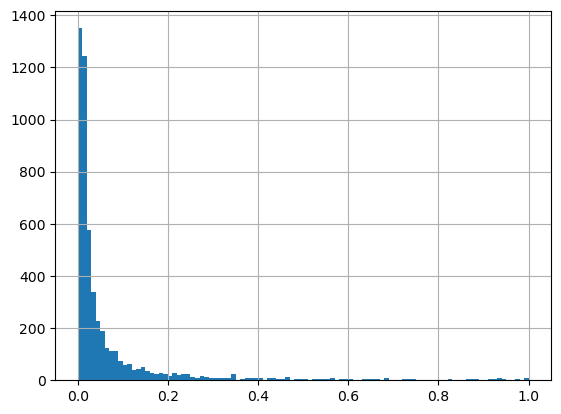

In [37]:
# Distribution of maxsplai in non-splice_DM
df_eval['maxsplai'] = df_eval['maxsplai'].astype(float)

In [2]:
# cast 
df_eval['maxsplai'] = df_eval['maxsplai'].astype(float)
df_eval['PriorityScore'] = df_eval['PriorityScore'].astype(int)

splai_2 = df_eval.loc[df_eval['maxsplai'] >= 0.2]
splai_5 = df_eval.loc[df_eval['maxsplai'] >= 0.5]
splai_8 = df_eval.loc[df_eval['maxsplai'] >= 0.8]
ps_3 = df_eval.loc[df_eval['PriorityScore'] >= 3]
ps_4 = df_eval.loc[df_eval['PriorityScore'] >= 4]
ps_5 = df_eval.loc[df_eval['PriorityScore'] >= 5]
ps_6 = df_eval.loc[df_eval['PriorityScore'] >= 6]

# calucrate false positive rate (FPR)
fpr_splai_2 = len(splai_2) / len(df_eval)
fpr_splai_5 = len(splai_5) / len(df_eval)
fpr_splai_8 = len(splai_8) / len(df_eval)
fpr_ps_3 = len(ps_3) / len(df_eval)
fpr_ps_4 = len(ps_4) / len(df_eval)
fpr_ps_5 = len(ps_5) / len(df_eval)
fpr_ps_6 = len(ps_6) / len(df_eval)


# Plot bar graph of FPR
import matplotlib.pyplot as plt
import seaborn as sns

fpr = [fpr_splai_2, fpr_splai_5, fpr_splai_8, fpr_ps_3, fpr_ps_4, fpr_ps_5, fpr_ps_6]
labels = ['SpliceAI >= 2', 'SpliceAI >= 5', 'SpliceAI >= 8', 'PriorityScore >= 3', 'PriorityScore >= 4', 'PriorityScore >= 5', 'PriorityScore >= 6']

plt.figure(figsize=(10, 6))
sns.barplot(x=labels, y=fpr)
plt.title('False Positive Rate')
plt.xlabel('Thresholds')
plt.ylabel('FPR')
plt.show()


NameError: name 'df_eval' is not defined

In [1]:
[fpr_splai_2, fpr_splai_5, fpr_splai_8, fpr_ps_3, fpr_ps_4]

NameError: name 'fpr_splai_2' is not defined

In [19]:
non_splice_mutations_sample['variant_id2']

134478                    16-68719191-1508G>A
70244              4-111539357-157_740del3059
145605                    X-154176123-1963T>C
174305                      5-41807456-817G>T
83190     18-60032270-731-1671_783+168del1892
                         ...                 
191681                    1-150530497-2254C>T
130789                     19-11216124-542C>G
373246                     11-88911744-623T>G
362845                     7-150439553-326C>T
166914                    15-31323243-3004A>T
Name: variant_id2, Length: 5000, dtype: object

In [18]:
df['is_non_splice_DM'].value_counts()

is_non_splice_DM
False    250733
Name: count, dtype: int64

In [72]:
for row in df.itertuples():
	if row.variant_id2 in non_splice_mutations_variants:
		# df.at[row.Index, 'is_non_splice_DM'] = True
		print(row.variant_id2)

KeyboardInterrupt: 

In [64]:
len(df['variant_id2'])

250733

In [34]:
len(allmut)

510804

In [2]:
def _liftover_to_hg19(chrom, pos):
    converter = get_lifter('hg38', 'hg19')
    result = converter.query(chrom, pos)
    if result:
        return result[0]
    else:
        return None
    
def anno_vars_id(row):
    variant_id = f'{row["CHROM"]}:{row["POS_hg19"]}-{row["REF"]}-{row["ALT"]}'
    return variant_id

def anno_hg19_pos(row):
    converted = _liftover_to_hg19(row['CHROM'], row['POS_hg38'])
    return converted[1]

def remove_dot_ver(x):
    if x == '.':
        pass
    else:
        return re.match(r'[a-zA-Z_]+\d+', x).group()
    
def remove_non_canon(x):
    if x in enst_set:
        return True
    else:
        pass

def create_refalt(row, nt):
    if row['Strand'] == '+':
        return row[nt]
    elif row['Strand'] == '-':
        return str(Seq(row[nt]).complement())
    else:
        pass

In [3]:
canonlist = '/Github/Projects/DeNovo/data/CanonicalTranscripts_COMP/CanonicalTranscripts.exoncount.tsv'
refseq = '/work/CanonicalTrasncripts/gencode.v43lift37.metadata.RefSeq.gz'

df_canon = pd.read_table(canonlist, header=0)
df_canon = df_canon[(df_canon['ENST'] != 'ENST00000649912')
                    & (df_canon['ENST'] != 'ENST00000609375')]
df_enst = df_canon.drop_duplicates(subset='ENST')
enst_set = set(df_enst['ENST'])
df_refseq = pd.read_table(refseq, header=None, 
                          names=['ENST_refseq', 'RefSeq_RNA', 'RefSeq_Pro'])
df_refseq.fillna(value='.', inplace=True)

df_refseq['ENST_refseq'] = df_refseq['ENST_refseq'].apply(remove_dot_ver)
df_refseq['RefSeq_RNA'] = df_refseq['RefSeq_RNA'].apply(remove_dot_ver)
df_refseq['RefSeq_Pro'] = df_refseq['RefSeq_Pro'].apply(remove_dot_ver)

df_refseq['is_Canonical'] =  df_refseq['ENST_refseq'].apply(remove_non_canon)
df_refseq_canon = df_refseq[df_refseq['is_Canonical'] == True].copy()

##### Generate VCF

In [4]:
# Loading HGMD splicing variants list (tsv)
hgmd_file = '/Github/MyProjects/DeNovo/data/ValidationData/Positive/allmut.trim.colfixed.maf0.tsv.txt'
df = pd.read_table(hgmd_file, header=0)

# Pre-processing
df = df.dropna(subset=['startCoord'])
df['startCoord'] = df['startCoord'].astype(int)
df['refseq'] = df['refseq'].apply(remove_dot_ver)

# Extract REF and ALT from HGVS descriptions
sr_alt_nt = df['hgvs'].str[-1:].rename('alt_nt')
sr_ref_nt = df['hgvs'].str[-3:-2].rename('ref_nt')
df = pd.concat([df, sr_ref_nt, sr_alt_nt], axis=1)

# Insert cols as VCF
df.loc[:,'ID'] = '.'
df.loc[:,'QUAL'] = '.'
df.loc[:,'FILTER'] = '.'
df.loc[:,'INFO'] = '.'

# Annotate ENST IDs
df = pd.merge(df, df_enst, how='left', 
              left_on='gene', right_on='GeneSymbol')

# Rename cols for downstream processing
df = df.rename(columns={'CHROM': 'Chr',
                        'chromosome': 'CHROM', 
                        'startCoord': 'POS_hg38'})

# Create REF and ALT columns
df['REF'] = df.apply(create_refalt, nt='ref_nt', axis=1)
df['ALT'] = df.apply(create_refalt, nt='alt_nt', axis=1)

In [5]:
# Liftover to hg19
df['POS_hg19'] = df.apply(anno_hg19_pos, axis=1)

In [ ]:
df2 = df.copy()
df2 = df2.astype({'POS_hg19': str})

# Annotate variant IDs
df2['variant_id'] = df2.apply(anno_vars_id, axis=1)

# Extract columns for VCF
df_19 = df2[['CHROM', 'POS_hg19', 
             'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO']]
df_38 = df2[['CHROM', 'POS_hg38', 
             'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO']]

In [265]:
df_19 = df_19.dropna(subset=['REF'])
df_38 = df_38.dropna(subset=['REF'])

In [266]:
# Output as VCF
df_19.to_csv('./patho.hg19.vcf', sep='\t', index=False, header=False)
df_38.to_csv('./patho.hg38.vcf', sep='\t', index=False, header=False)

##### Concatenate header and variant list

In [267]:
!cat ../header_for_VCF.tsv ./patho.hg19.vcf > patho.hg19.header.vcf
!cat ../header_for_VCF.tsv ./patho.hg38.vcf > patho.hg38.header.vcf

In [263]:
df[['Strand', 'ref_nt', 'REF', 'alt_nt', 'ALT']]

,Strand,ref_nt,REF,alt_nt,ALT
0,+,A,A,G,G
1,-,T,A,G,C
2,-,G,C,A,T
3,+,A,A,G,G
4,-,A,T,G,C
...,...,...,...,...,...
10553,NaN,G,None,A,None
10554,+,G,G,A,A
10555,-,G,C,A,T
10556,-,G,C,A,T


In [277]:
df2 =df2[['gene', 'gdbid', 'omimid', 'amino', 'codon', 'codonAff', 'descr',
       'refseq', 'hgvs', 'CHROM', 'POS_hg38', 'endCoord', 
       'expected_inheritance', 'dmsupport', 'mutype', 'acc_num', 'new_date', 
       'clinvarID', 'clinvar_clnsig', 'Chr', 'Start', 'End', 'Strand', 
       'GeneSymbol', 'HGNC_ID', 'ENSG', 'ENST', 'GeneType', 'Tag', 
       'REF', 'ALT', 'POS_hg19', 'variant_id']]

In [278]:
df2.to_csv('./patho2.tsv', sep='\t', index=False)

In [ ]:
#解除後の賃料はどうなっているか